In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed


In [3]:
tr_data, ts_data = tf.keras.datasets.mnist.load_data()
tr_X, tr_y = tr_data
ts_X, ts_y = ts_data
tr_X = tr_X.reshape(60000, 784).astype("float32") / 255
ts_X = ts_X.reshape(10000, 784).astype("float32") / 255

In [4]:
vae = VariationalAutoEncoder(784, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

history = vae.fit(tr_X, tr_X, validation_data=(ts_X, ts_X), epochs=10, batch_size=64, validation_freq=2)

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0946
Epoch 2/10
938/938 [==============================] - 2s 3ms/step - loss: 0.0675 - val_loss: 0.0678
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0675
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0675 - val_loss: 0.0677
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0675
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0673 - val_loss: 0.0677
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0673
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0674
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0676


In [5]:
from sklearn.decomposition import PCA
import umap

pca = PCA(n_components=10, svd_solver='arpack')
pca_ts = pca.fit_transform(ts_X)
emb_ts = umap.UMAP(random_state=42).fit_transform(pca_ts)

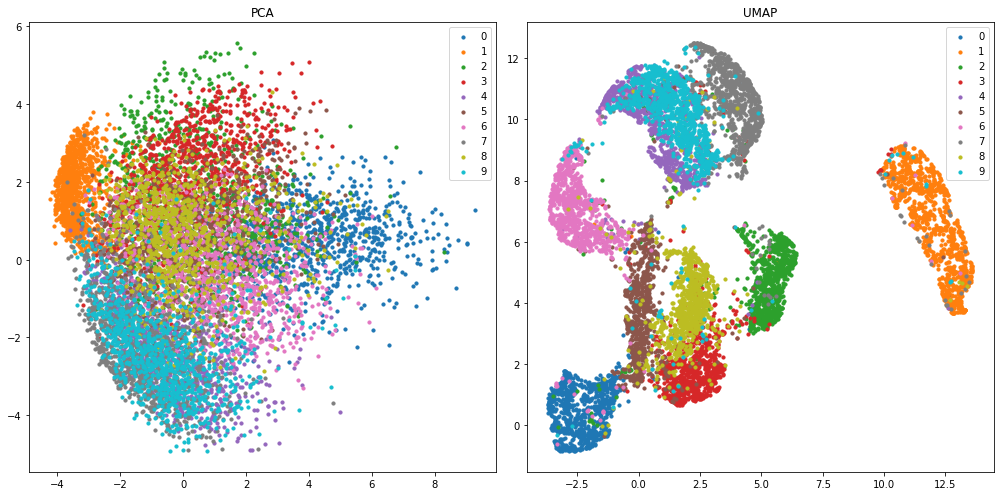

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_proj(x, y, ax):
    for label in np.unique(y):
        m = y == label
        ax.scatter(x[m,0], x[m,1], label=label, s=10)
        ax.legend()

fig, ax = plt.subplots(1,2, figsize=(14,7), tight_layout=True, facecolor='white')
ax = ax.flatten()

ax[0].set_title('PCA')
plot_proj(pca_ts, ts_y, ax=ax[0])

ax[1].set_title('UMAP')
plot_proj(emb_ts, ts_y, ax=ax[1])

fig.set_facecolor('white')